In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision import transforms
import numpy as np
import os
from tqdm.notebook import tqdm


from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

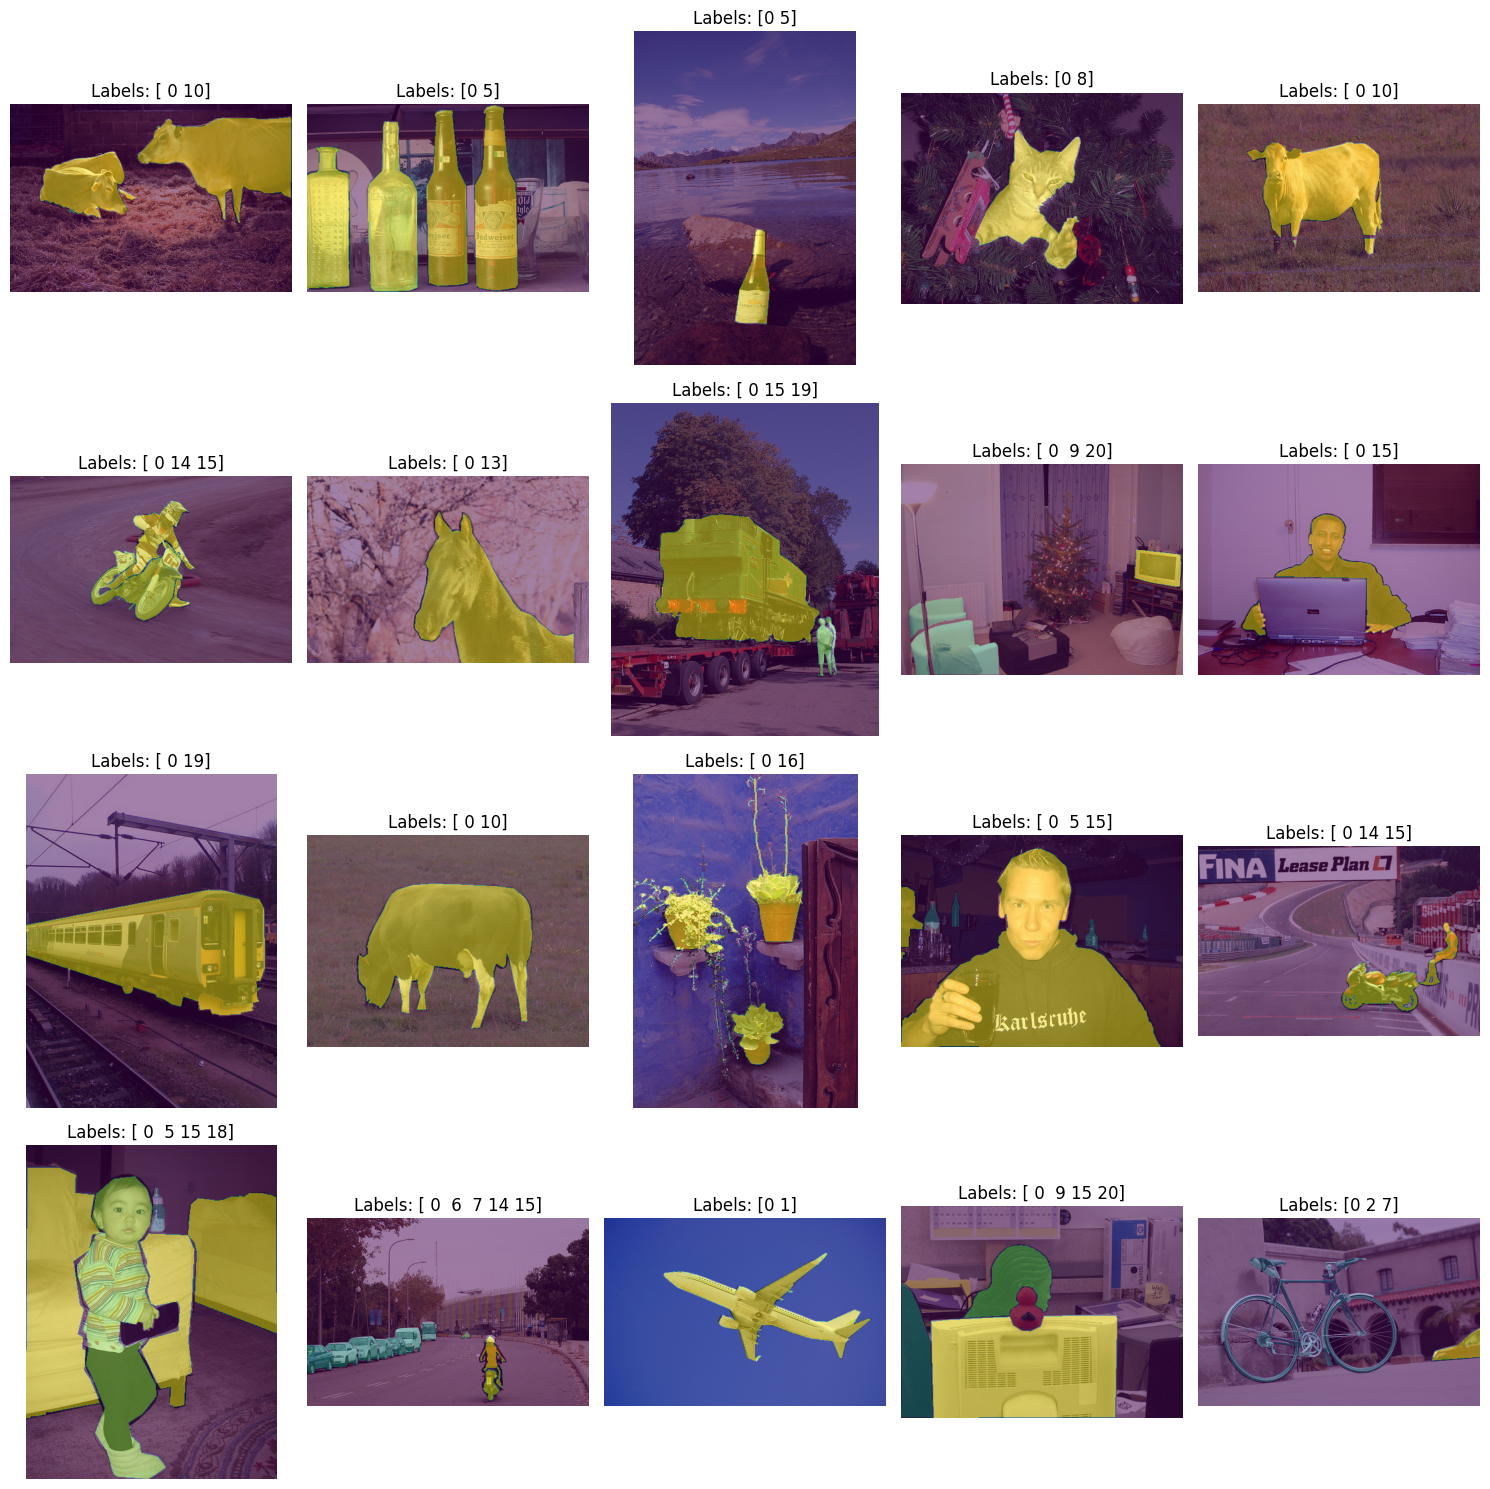

In [3]:
import matplotlib.pyplot as plt

num_images = 20
num_rows = 4
num_cols = num_images // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i in range(num_images):
    # Get the image for the current loop iteration
    img = np.load(f'/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/train/img/train_{i}.npy')
    mask = np.load(f'/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/train/seg/train_{i}.npy')
    
    # Calculate the row and column index for the current image
    row_idx = i // num_cols
    col_idx = i % num_cols
    labels = np.unique(mask)
    # Plot the image
    axes[row_idx, col_idx].imshow(img)
    axes[row_idx, col_idx].imshow(mask, alpha=0.5)
    axes[row_idx, col_idx].axis('off')
    axes[row_idx, col_idx].set_title(f'Labels: {labels}')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


# plt.imshow(image0)
# plt.imshow(mask0, alpha=0.5)





# Creating a custom dataset class 

Not using normalisation for now (does not work well)

In [5]:

class CustomDataset(Dataset):
    def __init__(self, data_folder, img_size, image_files, transform=None):
        self.data_folder = data_folder
        self.img_size = img_size
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.data_folder, 'img', self.image_files[idx])
        image = np.load(img_path)

        # Load mask
        mask_path = os.path.join(self.data_folder, 'seg', self.image_files[idx])
        mask = np.load(mask_path)

        # Resize image and mask
        image = resize(image, self.img_size, anti_aliasing=True)
        mask = resize(mask, self.img_size, anti_aliasing=False, order=0)

        # Convert image and mask to PyTorch tensors
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).long()
        
        
        if self.transform:
            image = self.transform(image)

        return (image, mask)


normalize = transforms.Normalize(mean=[0.4552, 0.4438, 0.4090], std=[0.2319, 0.2270, 0.2325])



transform = transforms.Compose([ 
    normalize  
])




train_folder = "/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/train/"
img_size = (256, 256)

image_files = sorted(os.listdir(os.path.join(train_folder, 'img')))

train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

train_dataset = CustomDataset(train_folder, img_size, train_files)
val_dataset = CustomDataset(train_folder, img_size, val_files)

full_dataset = CustomDataset(train_folder, img_size, image_files)

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for normalisation (not used now) 

In [6]:

def calculate_mean_std(dataset):
    # Initialize lists to store channel-wise means and standard deviations
    mean_list = []
    std_list = []

    # Iterate over the dataset to compute mean and standard deviation
    for sample in dataset:
        image = sample[0]  # Assuming the image is the first element of the sample
        # Compute mean and standard deviation along height, width, and channel dimensions
        mean = torch.mean(image, dim=(1, 2))
        std = torch.std(image, dim=(1, 2))
        mean_list.append(mean)
        std_list.append(std)

    mean_tensor = torch.stack(mean_list)
    std_tensor = torch.stack(std_list)

    dataset_mean = torch.mean(mean_tensor, dim=0)
    dataset_std = torch.mean(std_tensor, dim=0)

    return dataset_mean, dataset_std

train_mean, train_std = calculate_mean_std(full_dataset)

In [5]:
train_mean


tensor([0.4552, 0.4438, 0.4090])

In [16]:
full_dataset[0][0].mean()

tensor(0.2884)

Plotting some examples using the dataloader to check if the dataloader does not corrupt anything 

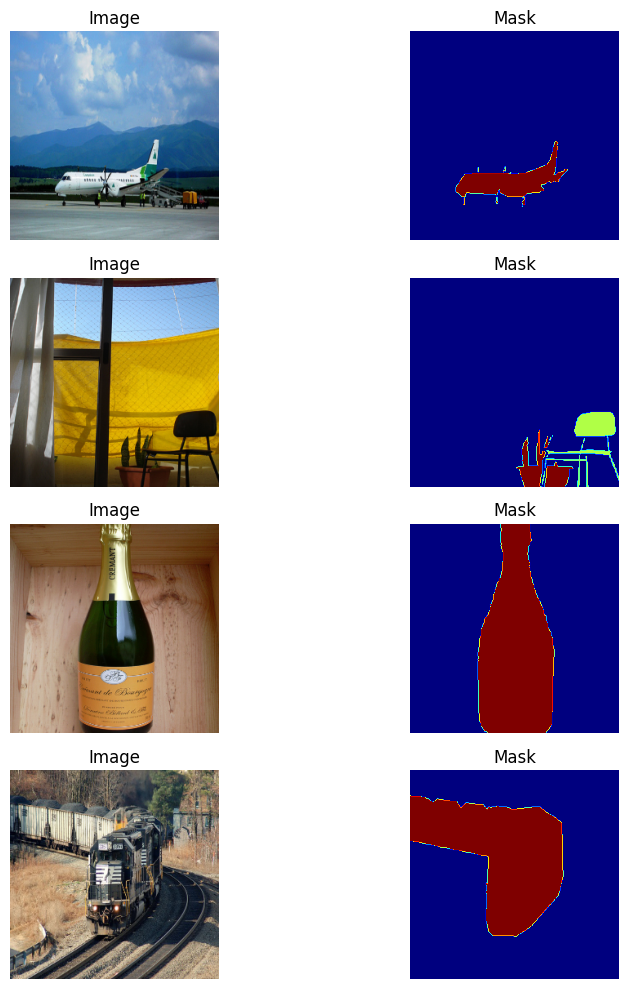

In [8]:
def plot_examples(images, masks, num_examples=4):
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, 10))
    for i in range(num_examples):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        mask = masks[i].cpu().numpy()
        
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image')

        axes[i, 1].imshow(mask, cmap='jet', vmin=0, vmax=mask.max())
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Mask')

    plt.tight_layout()
    plt.show()
batch_images, batch_masks = next(iter(train_loader))

# Plot a few example images
plot_examples(batch_images, batch_masks)

#### Checking the bincount to see what classes are represented in the last image

In [9]:
np.bincount(mask.flatten())

array([150293,      0,  13771,      0,      0,      0,      0,   2436])

## Defining the model

check out https://pytorch.org/vision/stable/models.html for more info (other models, loading weights etc)


Here we describe the FCN Model a bit. See paper by Long et al : Fully Convolutional Networks for Semantic Segmentation https://arxiv.org/pdf/1411.4038

In [33]:
num_classes = 21
learning_rate =1e-3
num_epochs = 100
img_size = (256, 256)

In [5]:
from torchvision.models.segmentation import fcn_resnet50

In [12]:
model = fcn_resnet50(num_classes=21)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s] 


In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)


In [55]:
device = 'cuda'

#### The training loop, for which I also employed IoU in validation

In [56]:
def compute_iou(outputs, masks):
    # Convert outputs to binary predictions
    predictions = torch.argmax(outputs, dim=1)
    
    # Compute intersection and union
    intersection = torch.sum(predictions & masks)
    union = torch.sum(predictions | masks)
    
    # Avoid division by zero
    iou = torch.true_divide(intersection, union + 1e-8)
    
    return iou

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to the appropriate device
    
    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses
    train_ious = []    # List to store training IoU
    val_ious = []      # List to store validation IoU

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        running_train_iou = 0.0
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for images, masks in train_loader:
                # Move images and masks to device
                images = images.to(device)
                masks = masks.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(images)['out']

                # Calculate loss
                loss = criterion(outputs, masks)
                
                # Compute IoU
                iou = compute_iou(outputs, masks)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Update training loss and IoU
                running_train_loss += loss.item() * images.size(0)
                running_train_iou += iou.item() * images.size(0)
                pbar.set_postfix({'Training Loss': running_train_loss / ((pbar.n + 1) * train_loader.batch_size),
                                  'Training IoU': running_train_iou / ((pbar.n + 1) * train_loader.batch_size)})
                pbar.update()

        # Calculate average training loss and IoU
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_iou = running_train_iou / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)  # Append to training loss history
        train_ious.append(epoch_train_iou)      # Append to training IoU history

        # Evaluate on validation set
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        running_val_iou = 0.0
        with torch.no_grad(), tqdm(total=len(val_loader), desc=f'Validation', unit='batch') as pbar:
            for val_images, val_masks in val_loader:
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)['out']
                val_loss = criterion(val_outputs, val_masks)
                
                # Compute IoU
                val_iou = compute_iou(val_outputs, val_masks)

                running_val_loss += val_loss.item() * val_images.size(0)
                running_val_iou += val_iou.item() * val_images.size(0)
                pbar.set_postfix({'Validation Loss': running_val_loss / ((pbar.n + 1) * val_loader.batch_size),
                                  'Validation IoU': running_val_iou / ((pbar.n + 1) * val_loader.batch_size)})
                pbar.update()

        # Calculate average validation loss and IoU
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_iou = running_val_iou / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)  # Append to validation loss history
        val_ious.append(epoch_val_iou)      # Append to validation IoU history

    return train_losses, val_losses, train_ious, val_ious



# Train the model
train_losses, val_losses, train_ious, val_ious = train(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoch 1/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 2/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 3/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 4/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 5/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 6/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 7/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 8/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 9/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 10/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 11/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 12/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 13/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 14/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 15/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 16/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 17/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 18/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 19/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 20/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 21/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 22/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 23/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 24/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 25/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 26/100:   0%|          | 0/75 [00:00<?, ?batch/s]

KeyboardInterrupt: 

## Plotting the training curves

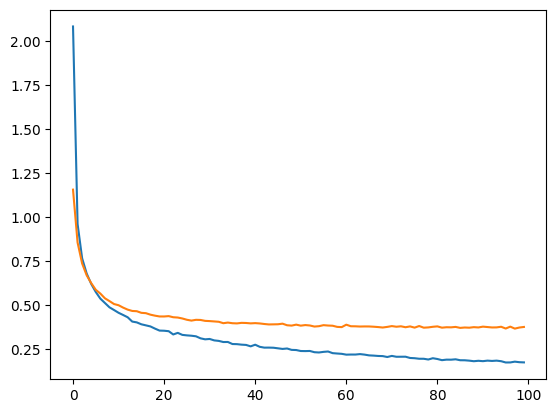

In [58]:
plt.plot(train_losses)
plt.plot(val_losses)

### Saving the model

In [6]:
torch.save(model.state_dict(), f'FCN_resnet50_LR{learning_rate}_{num_epochs}epoch.pth')

NameError: name 'model' is not defined

In [95]:
# class TestDataset(Dataset):
#     def __init__(self, data_folder, img_size, image_files=None):
#         self.data_folder = data_folder
#         self.img_size = img_size

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.data_folder, 'img', f'test_{idx}.npy')
#         image = np.load(img_path)

#         image = resize(image, self.img_size, anti_aliasing=True)

#         image = torch.from_numpy(image).permute(2, 0, 1).float()
#         return image



# test_folder = "/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/test/"

# test_dataset = TestDataset(test_folder, img_size)

# batch_size = 16
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Testing the model


## Load the model back in 

In [7]:
num_classes =21
# Create a new instance of your model
model = fcn_resnet50(pretrained=False, progress=True, num_classes=num_classes)

# Load the saved model parameters
model.load_state_dict(torch.load('/kaggle/input/resnet_50_fcn/pytorch/v/1/FCN_resnet50_LR0.0001_100epoch.pth'))


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 162MB/s] 


<All keys matched successfully>

#### Defining a test loader

In [8]:
import re
img_size = (256,256)
class TestDataset(Dataset):
    def __init__(self, data_folder, img_size, image_files):
        self.data_folder = data_folder
        self.img_size = img_size
        self.image_files = sorted(image_files, key=lambda x: int(re.findall(r'\d+', x)[0])) 

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.data_folder, 'img', self.image_files[idx])
        image = np.load(img_path)

        # Resize image
        image = resize(image, self.img_size, anti_aliasing=True)

        # Convert image to PyTorch tensor
        image = torch.from_numpy(image).permute(2, 0, 1).float()

        return image

# Example usage

test_folder = "/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/test/"

# List all image files in the test folder
test_image_files = sorted(os.listdir(os.path.join(test_folder, 'img')))

# Create TestDataset instance for the test set
test_dataset = TestDataset(test_folder, img_size, test_image_files)

batch_size = 16
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Make the predictions 

In [9]:
def make_predictions(model, test_loader):
    device = next(model.parameters()).device  # Get the device of the model's parameters
    model.eval()  # Set model to evaluation mode
    predictions = []
    with torch.no_grad():
        for images_batch in tqdm(test_loader):
            images_batch = images_batch.to(device)  # Move input data to the same device as the model
            outputs = model(images_batch)['out']
            predictions.append(outputs)
    return torch.cat(predictions)

In [10]:
test_predictions = make_predictions(model, test_loader)

  0%|          | 0/47 [00:00<?, ?it/s]

In [11]:
test_predictions.shape

torch.Size([750, 21, 256, 256])

### Plotting some predictions 

[61925     0     0     0     0     0     0     0     0     0     0     0
     0     0     0  3496     0     0     0     0   115]
[51833     0     0     0     0     0     0     0     0 13078     0   407
     0     0     0     0   138     0    80]
[47003     0     0     0     0     0     0     0     0  3703     0  2236
     0     0     0     0     0     0 12594]
[64627     0   508     0     0     0     0     0     0     0     0     0
     0     0     0   401]
[56537     0     0     0     0     0     0     0     0  1790     0     0
     0     0     0  7209]
[64706     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   830]
[59384     0     0     0  6152]
[56461     0     0     0     0     0     0     0     0     0     0     0
     0  8440     0   635]
[54861     0     0     0     0     0     0     0     0     0     0     0
     0     0     0  9415     0     0     0  1260]
[50797     0     0     0     0     0     0   116     0  

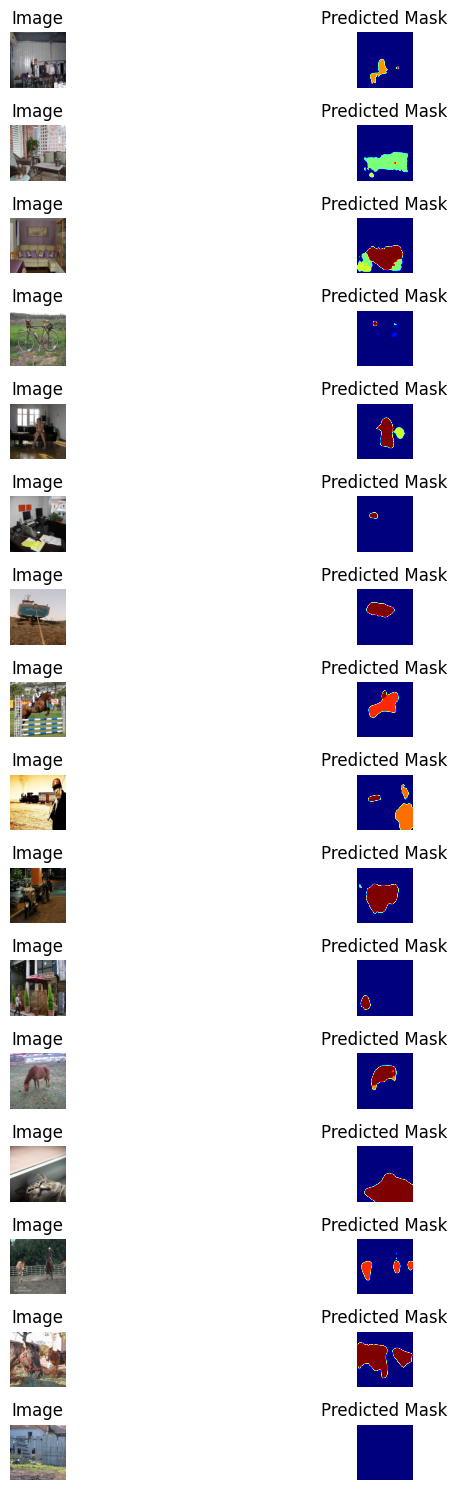

In [37]:
# Plot some example predictions
def plot_test_predictions(test_dataset, test_predictions, num_examples=16):
    test_loader = DataLoader(test_dataset, batch_size=num_examples, shuffle=False)
    images_batch = next(iter(test_loader))
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, 15))
    for i in range(num_examples):
        image = images_batch[i].permute(1, 2, 0).cpu().numpy()
        prediction = test_predictions[i].argmax(dim=0).cpu().numpy()  # Convert logits to class predictions
        print(np.bincount(prediction.flatten()))
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image')

        axes[i, 1].imshow(prediction, cmap='jet', vmin=0, vmax=prediction.max())
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()

# Plot some example predictions
plot_test_predictions(test_dataset, test_predictions)


## Filling the test dataframe for submission

In [12]:
test_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/test/test_set.csv', index_col="Id")
test_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))


The test set contains 750 examples.


In [13]:
test_df.head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,img,seg
Id,,,,,,,,,,,,,,,,,,,,,
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,"[[[139, 130, 115], [136, 127, 112], [112, 102,...","[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,"[[[146, 95, 92], [131, 87, 84], [156, 137, 133...","[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,"[[[121, 122, 108], [121, 122, 106], [125, 122,...","[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,"[[[71, 69, 74], [73, 71, 76], [80, 78, 83], [7...","[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."


In [14]:
torch.save(test_predictions, 'seg2.pth')

In [15]:
# populating the dataframe for submission


import pandas as pd

model.eval()

for idx, row in tqdm(test_df.iterrows(), total = len(test_dataset)):
    
    
    segmentation_mask = test_predictions[i].argmax(dim=0).cpu().numpy()
    
    # Resize the segmentation mask to match the original image size
    resized_segmentation_mask = resize(segmentation_mask, row['seg'].shape, anti_aliasing=False, order=0)
    
    # Update the seg column in the test dataframe with the resized segmentation mask
    test_df.at[idx, 'seg'] = resized_segmentation_mask

  0%|          | 0/750 [00:00<?, ?it/s]

In [19]:
test_df.iloc(0)[0]['seg']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
np.bincount(test_df.iloc(0)[0]["seg"].flatten())

array([119111,      0,      0,      0,      0,      0,      0,  68389])

In [21]:
test_df.to_csv("test_df.csv")

In [16]:
test_df.to_pickle("test_df.pkl")

# Trying the model with pretrained weights

Here we will preload the model with the according resnet weights and 

In [17]:
num_classes = 21
learning_rate =1e-3
num_epochs = 100
img_size = (256, 256)

In [19]:
from torchvision.models.segmentation import fcn_resnet50
from torchvision.models import resnet50, ResNet50_Weights

In [20]:
weights = ResNet50_Weights.IMAGENET1K_V2
model = fcn_resnet50(num_classes=21, weights_backbone=weights)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s] 


In [27]:
from torch.optim.lr_scheduler import CosineAnnealingLR
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)


scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.01)

In [28]:
device = 'cuda'

#### The training loop, for which I also employed IoU in validation

In [29]:
def compute_iou(outputs, masks):
    # Convert outputs to binary predictions
    predictions = torch.argmax(outputs, dim=1)
    
    # Compute intersection and union
    intersection = torch.sum(predictions & masks)
    union = torch.sum(predictions | masks)
    
    # Avoid division by zero
    iou = torch.true_divide(intersection, union + 1e-8)
    
    return iou

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to the appropriate device
    
    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses
    train_ious = []    # List to store training IoU
    val_ious = []      # List to store validation IoU

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        running_train_iou = 0.0
        
        scheduler.step()
        
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for images, masks in train_loader:
                # Move images and masks to device
                images = images.to(device)
                masks = masks.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(images)['out']

                # Calculate loss
                loss = criterion(outputs, masks)
                
                # Compute IoU
                iou = compute_iou(outputs, masks)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Update training loss and IoU
                running_train_loss += loss.item() * images.size(0)
                running_train_iou += iou.item() * images.size(0)
                pbar.set_postfix({'Training Loss': running_train_loss / ((pbar.n + 1) * train_loader.batch_size),
                                  'Training IoU': running_train_iou / ((pbar.n + 1) * train_loader.batch_size)})
                pbar.update()

        # Calculate average training loss and IoU
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_iou = running_train_iou / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)  # Append to training loss history
        train_ious.append(epoch_train_iou)      # Append to training IoU history

        # Evaluate on validation set
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        running_val_iou = 0.0
        with torch.no_grad(), tqdm(total=len(val_loader), desc=f'Validation', unit='batch') as pbar:
            for val_images, val_masks in val_loader:
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)['out']
                val_loss = criterion(val_outputs, val_masks)
                
                # Compute IoU
                val_iou = compute_iou(val_outputs, val_masks)

                running_val_loss += val_loss.item() * val_images.size(0)
                running_val_iou += val_iou.item() * val_images.size(0)
                pbar.set_postfix({'Validation Loss': running_val_loss / ((pbar.n + 1) * val_loader.batch_size),
                                  'Validation IoU': running_val_iou / ((pbar.n + 1) * val_loader.batch_size)})
                pbar.update()

        # Calculate average validation loss and IoU
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_iou = running_val_iou / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)  # Append to validation loss history
        val_ious.append(epoch_val_iou)      # Append to validation IoU history

    return train_losses, val_losses, train_ious, val_ious



# Train the model
train_losses, val_losses, train_ious, val_ious = train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 2/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 3/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 4/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 5/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 6/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 7/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 8/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 9/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 10/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 11/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 12/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 13/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 14/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 15/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 16/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 17/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 18/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 19/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 20/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 21/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 22/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 23/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 24/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 25/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 26/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 27/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 28/100:   0%|          | 0/75 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [31]:
torch.save(model.state_dict(), "FCN_cosan_pretrained.pth")

In [32]:
plt.plot(train_losses)

NameError: name 'train_losses' is not defined

## Building a larger Unet

In [62]:
import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

model = ResNetUNet(21)
model = model.to(device)

device cuda


In [72]:
! pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.9 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=072f696e14d34db81b2e0b8c0daf0dd155ad7a7944103598213094178b1773da
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=109af2e156b0760a4c9c999cdc67d84dadf7be3da35e58b0a78a273e38d7de91
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built ef

In [76]:
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    #encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=21,                      # model output channels (number of classes in your dataset)
)

In [78]:
from torch.optim import lr_scheduler  


In [79]:
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)
#lr_scheduler = StepLR(optimizer_ft, step_size=30, gamma=0.1)

In [80]:
def compute_iou(outputs, masks):
    # Convert outputs to binary predictions
    predictions = torch.argmax(outputs, dim=1)
    
    # Compute intersection and union
    intersection = torch.sum(predictions & masks)
    union = torch.sum(predictions | masks)
    
    # Avoid division by zero
    iou = torch.true_divide(intersection, union + 1e-8)
    
    return iou

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to the appropriate device
    
    train_losses = []  # List to store training losses
    val_losses = []    # List to store validation losses
    train_ious = []    # List to store training IoU
    val_ious = []      # List to store validation IoU

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        running_train_iou = 0.0
        
        scheduler.step()
        
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for images, masks in train_loader:
                # Move images and masks to device
                images = images.to(device)
                masks = masks.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(images)

                # Calculate loss
                loss = criterion(outputs, masks)
                
                # Compute IoU
                iou = compute_iou(outputs, masks)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Update training loss and IoU
                running_train_loss += loss.item() * images.size(0)
                running_train_iou += iou.item() * images.size(0)
                pbar.set_postfix({'Training Loss': running_train_loss / ((pbar.n + 1) * train_loader.batch_size),
                                  'Training IoU': running_train_iou / ((pbar.n + 1) * train_loader.batch_size)})
                pbar.update()

        # Calculate average training loss and IoU
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_iou = running_train_iou / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)  # Append to training loss history
        train_ious.append(epoch_train_iou)      # Append to training IoU history

        # Evaluate on validation set
        model.eval()  # Set model to evaluation mode
        running_val_loss = 0.0
        running_val_iou = 0.0
        with torch.no_grad(), tqdm(total=len(val_loader), desc=f'Validation', unit='batch') as pbar:
            for val_images, val_masks in val_loader:
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                
                # Compute IoU
                val_iou = compute_iou(val_outputs, val_masks)

                running_val_loss += val_loss.item() * val_images.size(0)
                running_val_iou += val_iou.item() * val_images.size(0)
                pbar.set_postfix({'Validation Loss': running_val_loss / ((pbar.n + 1) * val_loader.batch_size),
                                  'Validation IoU': running_val_iou / ((pbar.n + 1) * val_loader.batch_size)})
                pbar.update()

        # Calculate average validation loss and IoU
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_iou = running_val_iou / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)  # Append to validation loss history
        val_ious.append(epoch_val_iou)      # Append to validation IoU history

    return train_losses, val_losses, train_ious, val_ious



# Train the model
train_losses, val_losses, train_ious, val_ious = train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)


Epoch 1/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 2/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 3/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 4/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 5/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 6/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 7/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 8/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 9/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 10/100:   0%|          | 0/75 [00:00<?, ?batch/s]

Validation:   0%|          | 0/19 [00:00<?, ?batch/s]

Epoch 11/100:   0%|          | 0/75 [00:00<?, ?batch/s]

KeyboardInterrupt: 